In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sklearn.metrics import classification_report, confusion_matrix

import multiprocessing

from utils.DomainImageGenerator import DomainImageGenerator

2025-07-14 12:03:12.116918: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 12:03:12.120452: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 12:03:12.131528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752487392.149821  588686 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752487392.155405  588686 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 12:03:12.174670: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# Load the Dataset as Generators so not all images are loaded into ram at the same time. The generator class loads the needed images per batch
cpu_count = multiprocessing.cpu_count()
njobs = int(cpu_count * 0.9) # Just set to use some percent of cpus
max_queue_size = 15
use_multiprocessing = True

model = load_model("../models/MinimlModel.keras")
test_gen = DomainImageGenerator("prepared/test.csv", batch_size=64, shuffle=False, n_jobs=njobs, use_multiprocessing=use_multiprocessing, max_queue_size=max_queue_size)

2025-07-14 12:03:15.087539: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9570 - loss: 0.1328
Test Accuracy: 0.9683
Test Loss: 0.0964


In [4]:
# Shuffle needs to be off for this to make sense. Shuffling can be done by hand with test_gen.shuffle_indexes()

test_gen.shuffle_indexes()
y_true = test_gen.getAllLabels()
y_pred = model.predict(test_gen)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


In [5]:
y_greater = y_pred[(y_pred > 0.5)]
predictions_greater_half = len(y_greater)

values = [0.6, 0.7, 0.8, 0.9, 0.95, 0.98]
print(f"There are {predictions_greater_half} predictions greater then 0.5")
for num in values:
    y_greater_num = y_greater[(y_greater > num)]
    print(f"\n{len(y_greater_num)} predictions are greater then {num}")
    print(f"That is {(len(y_greater_num)/predictions_greater_half) * 100:.1f} percent of all predictions greater then 0.5")

There are 71334 predictions greater then 0.5

70773 predictions are greater then 0.6
That is 99.2 percent of all predictions greater then 0.5

70128 predictions are greater then 0.7
That is 98.3 percent of all predictions greater then 0.5

69182 predictions are greater then 0.8
That is 97.0 percent of all predictions greater then 0.5

67334 predictions are greater then 0.9
That is 94.4 percent of all predictions greater then 0.5

64979 predictions are greater then 0.95
That is 91.1 percent of all predictions greater then 0.5

60100 predictions are greater then 0.98
That is 84.3 percent of all predictions greater then 0.5


In [6]:
y_less = y_pred[(y_pred < 0.5)]
predictions_less_half = len(y_less)

values = [0.4, 0.3, 0.2, 0.1, 0.05, 0.02]
print(f"There are {predictions_less_half} predictions less then 0.5")
for num in values:
    y_less_num = y_less[(y_less < num)]
    print(f"\n{len(y_less_num)} predictions are smaller then {num}")
    print(f"That is {(len(y_less_num)/predictions_less_half) * 100:.1f} percent of all predictions smaller then 0.5")

There are 18666 predictions less then 0.5

18137 predictions are smaller then 0.4
That is 97.2 percent of all predictions smaller then 0.5

17564 predictions are smaller then 0.3
That is 94.1 percent of all predictions smaller then 0.5

16874 predictions are smaller then 0.2
That is 90.4 percent of all predictions smaller then 0.5

15802 predictions are smaller then 0.1
That is 84.7 percent of all predictions smaller then 0.5

14708 predictions are smaller then 0.05
That is 78.8 percent of all predictions smaller then 0.5

13240 predictions are smaller then 0.02
That is 70.9 percent of all predictions smaller then 0.5


In [7]:
print(classification_report(y_true, y_pred_binary, target_names=["CIFAR-10", "ImageNet"]))

              precision    recall  f1-score   support

    CIFAR-10       0.96      0.90      0.93     20000
    ImageNet       0.97      0.99      0.98     70000

    accuracy                           0.97     90000
   macro avg       0.96      0.94      0.95     90000
weighted avg       0.97      0.97      0.97     90000



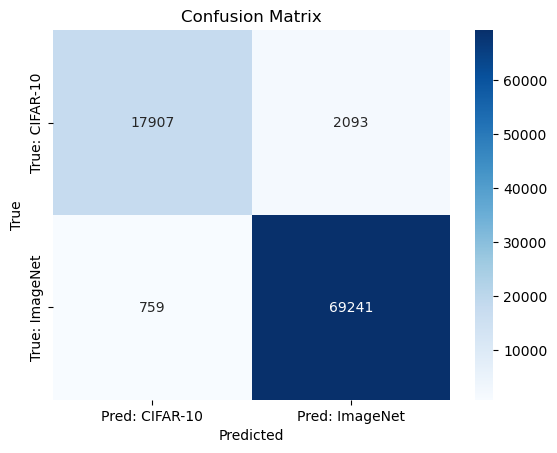

In [8]:
cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: CIFAR-10", "Pred: ImageNet"],
            yticklabels=["True: CIFAR-10", "True: ImageNet"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [9]:
indexes = test_gen.return_Indexes()
categories = test_gen.return_Category_by_Index(indexes)

In [10]:
# Build the DataFrame
df_images = pd.DataFrame({
    "index": indexes,
    "category": categories,
    "y_true": y_true,
    "prediction": y_pred.flatten()
})

In [11]:
df_cifar = df_images[df_images["y_true"] == 0].copy()
df_imagenet = df_images[df_images["y_true"] == 1].copy()

In [12]:
print(f"CIFAR-10: {len(df_cifar)} images")
print(f"ImageNet: {len(df_imagenet)} images")

print(df_cifar.head())
print(df_imagenet.head())

CIFAR-10: 20000 images
ImageNet: 70000 images
    index category  y_true  prediction
2   19066     bird       0    0.002073
7   63535    horse       0    0.000002
9   64674    horse       0    0.106771
20  37598     deer       0    0.000888
25  54230     frog       0    0.993920
   index    category  y_true  prediction
0  20122        bird       1    0.986978
1  11269  automobile       1    0.988547
3  30391         cat       1    0.071532
4  61099        frog       1    0.989198
5  15797  automobile       1    0.992601


In [13]:
print(np.unique(df_images["category"]))

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [14]:
def from_DataFrame_get_subDataFrame_of_category(df, category):
    return df[df["category"] == category]

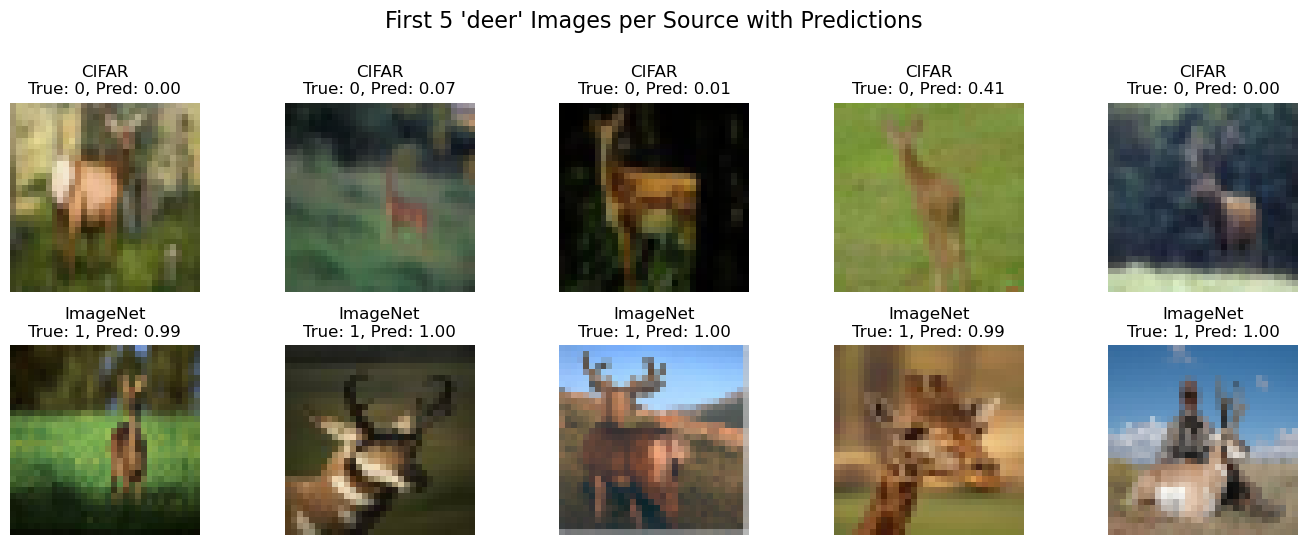

In [50]:
fig, axs = plt.subplots(2, 5, figsize=(14, 5))
category = "deer"

# Filter sub-DataFrames
cifar_sub_df = from_DataFrame_get_subDataFrame_of_category(df_cifar, category)
imagenet_sub_df = from_DataFrame_get_subDataFrame_of_category(df_imagenet, category)

# Get images by index
cifar_images = test_gen.return_Img_by_Index(cifar_sub_df["index"][:5])
imagenet_images = test_gen.return_Img_by_Index(imagenet_sub_df["index"][:5])

# CIFAR-10 (top row)
for i in range(5):
    img = cifar_images[i]
    row = cifar_sub_df.iloc[i]
    title = f"CIFAR\nTrue: {int(row['y_true'])}, Pred: {row['prediction']:.2f}"
    axs[0, i].imshow(img)
    axs[0, i].set_title(title)
    axs[0, i].axis("off")

# ImageNet (bottom row)
for i in range(5):
    img = imagenet_images[i]
    row = imagenet_sub_df.iloc[i]
    title = f"ImageNet\nTrue: {int(row['y_true'])}, Pred: {row['prediction']:.2f}"
    axs[1, i].imshow(img)
    axs[1, i].set_title(title)
    axs[1, i].axis("off")

plt.tight_layout()
plt.suptitle(f"First 5 '{category}' Images per Source with Predictions", y=1.08, fontsize=16)
plt.show()

In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 5)      │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1125)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │        18,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,521 (212.98 KB)

 Trainable params: 18,173 (70.99 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 36,348 (141.99 KB)

In [51]:
def visualize_activations(model, image, max_filters=6):
    """
    Visualize intermediate activations after each layer for a single image.

    Parameters:
    - model: Trained Keras model
    - image: Numpy array of shape (32, 32, 3)
    - max_filters: How many filters to display per conv layer
    """
    # Show original image
    fig, axs = plt.subplots(1, 4, figsize=(4 * 2.5, 2.5))
    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    for i in range(3):
        axs[i+1].imshow(image[:,:,i])
        axs[i+1].set_title(f"Original Image Channel {i+1}")
        axs[i+1].axis('off')
    plt.tight_layout()
    plt.show()
    
    # Prepare image as batch input
    img_input = np.expand_dims(image, axis=0)

    # Get intermediate outputs
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = Model(inputs=model.layers[0].input, outputs=layer_outputs)
    activations = activation_model.predict(img_input)

    # Visualize outputs
    for i, activation in enumerate(activations):
        if len(activation.shape) == 4:  # Conv/Pool layers: (1, H, W, C)
            num_filters = min(activation.shape[-1], max_filters)
            fig, axs = plt.subplots(1, num_filters, figsize=(num_filters * 2.5, 2.5))
            for j in range(num_filters):
                axs[j].imshow(activation[0, :, :, j], cmap='viridis')
                axs[j].axis('off')
                axs[j].set_title(f"Filter {j + 1}")
            plt.suptitle(f"Layer {i}: {model.layers[i].name} → shape {activation.shape[1:]}", fontsize=12)
            plt.tight_layout()
            plt.show()
        elif len(activation.shape) == 2:  # Dense layer: (1, N)
            print(f"Layer {i}: {model.layers[i].name} → Dense output shape: {activation.shape}")
            print(f"Output values (first 10): {activation[0][:36]}")


In [52]:
layer = model.layers[0] # layer.name returns 'conv2d'

# Extract weights from the Conv2D layer
kernels, biases = layer.get_weights()  # shape: (3, 3, 3, num_filters) for a 3x3 RGB kernel, num_filters filters
print("Kernel shape:", kernels.shape)
print(layer.input)

Kernel shape: (3, 3, 3, 5)
<KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=False, ragged=False, name=input_layer_1>


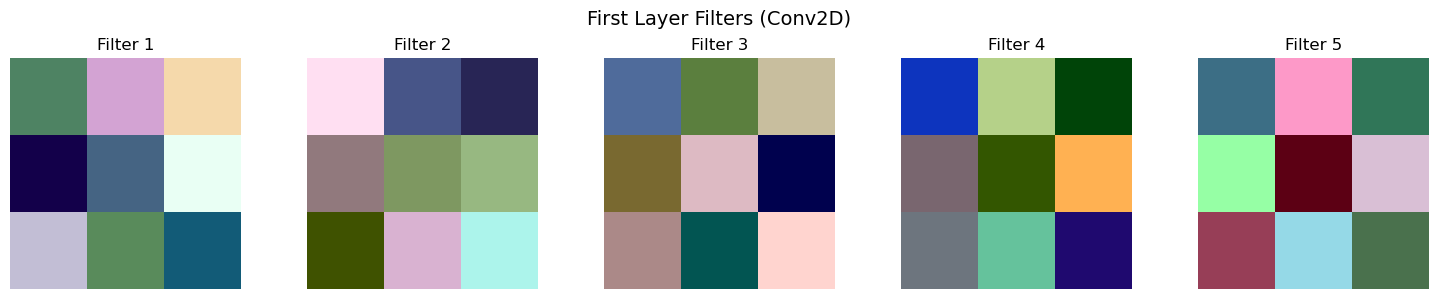

In [53]:
# Choose the first few filters
n_filters_to_show = 5
fig, axs = plt.subplots(1, n_filters_to_show, figsize=(15, 3))

for i in range(n_filters_to_show):
    # Normalize for visualization
    kernel = kernels[:, :, :, i]
    kernel_min, kernel_max = kernel.min(), kernel.max()
    kernel_vis = (kernel - kernel_min) / (kernel_max - kernel_min)

    axs[i].imshow(kernel_vis)
    axs[i].set_title(f"Filter {i+1}")
    axs[i].axis('off')

plt.suptitle("First Layer Filters (Conv2D)", fontsize=14)
plt.tight_layout()
plt.show()


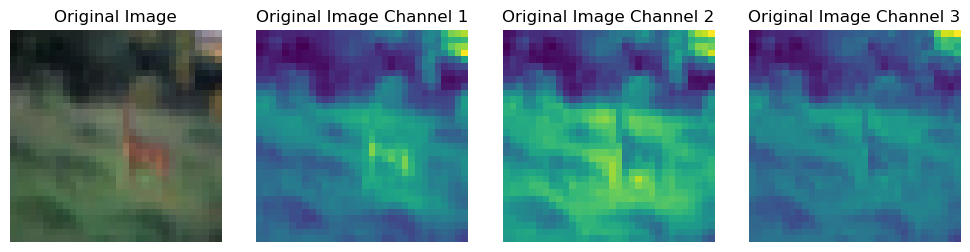

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


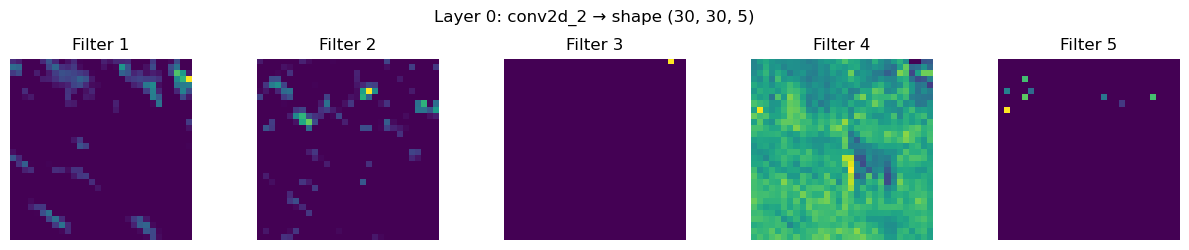

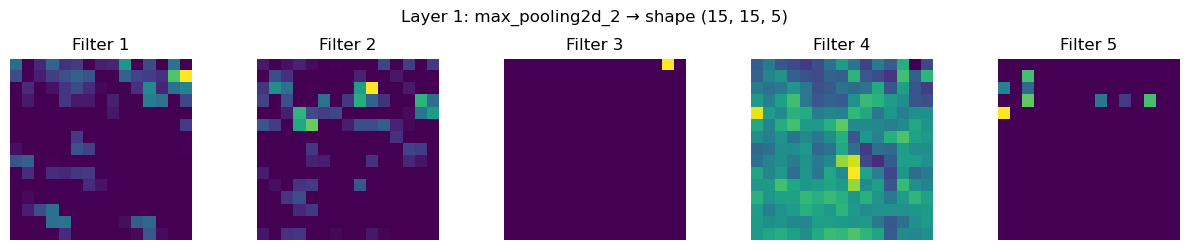

Layer 2: flatten_1 → Dense output shape: (1, 1125)
Output values (first 10): [0.10074908 0.01491217 0.         0.11331473 0.         0.
 0.         0.         0.12838264 0.         0.03295132 0.01012667
 0.         0.10955898 0.         0.09279389 0.01940179 0.
 0.10323033 0.         0.04050729 0.00661303 0.         0.09691251
 0.         0.04709411 0.         0.         0.10559817 0.
 0.         0.00189928 0.         0.12345668 0.         0.02556845]
Layer 3: dense_2 → Dense output shape: (1, 16)
Output values (first 10): [0.         3.8220234  0.8687808  0.92197424 0.         0.
 0.46251416 0.         1.0316675  0.         0.         0.
 0.         0.         0.         0.26090762]
Layer 4: dense_3 → Dense output shape: (1, 1)
Output values (first 10): [0.06894901]


In [54]:
img = cifar_images[1]
visualize_activations(model, img, max_filters=10)

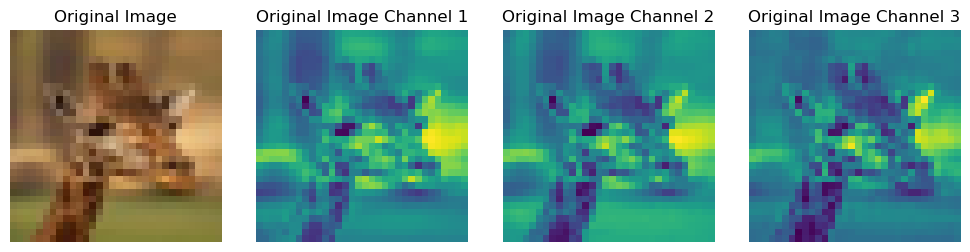

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


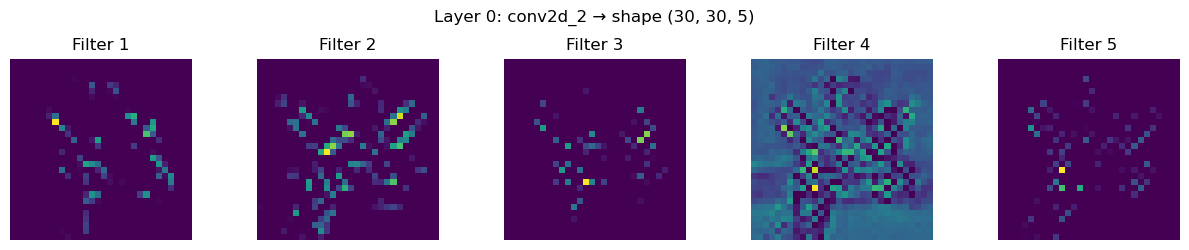

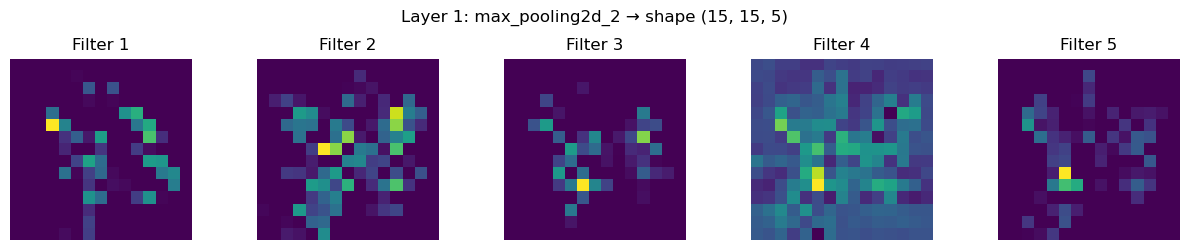

Layer 2: flatten_1 → Dense output shape: (1, 1125)
Output values (first 10): [0.         0.         0.         0.10860816 0.         0.
 0.         0.         0.11639684 0.         0.         0.
 0.         0.09970011 0.         0.         0.         0.
 0.09987602 0.         0.         0.         0.         0.08707296
 0.         0.         0.         0.         0.08724698 0.
 0.         0.         0.         0.10531911 0.         0.        ]
Layer 3: dense_2 → Dense output shape: (1, 16)
Output values (first 10): [0.         3.252761   0.         0.39558047 0.         0.
 0.         0.         0.         0.         0.         0.
 0.25282374 0.         0.         0.        ]
Layer 4: dense_3 → Dense output shape: (1, 1)
Output values (first 10): [0.9879709]


In [56]:
img = imagenet_images[3]
visualize_activations(model, img, max_filters=10)